### 패키지 임포트

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import datetime

In [65]:
import warnings
import matplotlib

In [69]:
warnings.filterwarnings(action="ignore")
matplotlib.rc('font', family='Malgun Gothic')
matplotlib.rcParams['axes.unicode_minus'] = False

## [서울특별시]

### 법정동코드 생성

In [277]:
# 서울 구단위 법정동코드 : "구"에서 앞 5개 수자의 법정코드 
df_code = pd.read_csv('법정동코드 전체자료.txt', sep="\t", encoding="cp949")

In [278]:
df_code_서울특별시 =df_code[(df_code["법정동명"].str.contains("서울특별시")) & (df_code["폐지여부"]=="존재")]

In [279]:
df_code_서울구=df_code_서울특별시[df_code_서울특별시["법정동명"].str.endswith("구") ]
df_code_서울구=df_code_서울구.reset_index(drop=True)
df_code_서울구["법정동코드"]=df_code_서울구["법정동코드"].astype("str")
df_code_서울구["법정동코드"]=df_code_서울구["법정동코드"].map(lambda x : x[0:5])

In [280]:
print(list(zip(df_code_서울구["법정동코드"],df_code_서울구["법정동명"])))

[('11110', '서울특별시 종로구'), ('11140', '서울특별시 중구'), ('11170', '서울특별시 용산구'), ('11200', '서울특별시 성동구'), ('11215', '서울특별시 광진구'), ('11230', '서울특별시 동대문구'), ('11260', '서울특별시 중랑구'), ('11290', '서울특별시 성북구'), ('11305', '서울특별시 강북구'), ('11320', '서울특별시 도봉구'), ('11350', '서울특별시 노원구'), ('11380', '서울특별시 은평구'), ('11410', '서울특별시 서대문구'), ('11440', '서울특별시 마포구'), ('11470', '서울특별시 양천구'), ('11500', '서울특별시 강서구'), ('11530', '서울특별시 구로구'), ('11545', '서울특별시 금천구'), ('11560', '서울특별시 영등포구'), ('11590', '서울특별시 동작구'), ('11620', '서울특별시 관악구'), ('11650', '서울특별시 서초구'), ('11680', '서울특별시 강남구'), ('11710', '서울특별시 송파구'), ('11740', '서울특별시 강동구')]


In [281]:
len(df_code_서울구["법정동코드"].unique())

25

In [282]:
# 기간 설정
date=['202201','202202','202203','202204','202205','202206','202207','202208','202209','202210','202211','202212',
      '202301', '202302']

### 웹 크롤링

In [28]:
# data.go.kr에서 "아파트매매 실거래자료" open api 검색
# LAWD_CD : 각 지역별 코드 행정표준코드관리시스템(www.code.go.kr)의 법정동코드 10자리 중 앞 5자리
# DEAL_YMD : 실거래 자료의 계약년월(6자리)
url = 'http://openapi.molit.go.kr:8081/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTrade'
headers= {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36"}
전체실거래=[]
for i, (code, name)  in enumerate(zip(df_code_서울구["법정동코드"],df_code_서울구["법정동명"])):
    for month in date:
        params ={'serviceKey' : '2v9BFwIA8yoMw1cY29jvpynp24zpowZcL+UpOr31S/sVqRxCT1fYaTHov1dhMMdEp1GNFkeLl9dAHmSl5z6NBw==','LAWD_CD' : code, 'DEAL_YMD' : month }
        response = requests.get(url, params=params, headers=headers)
        soup=BeautifulSoup(response.text,"xml")
        for item in soup.select("item"):
            실거래=[]
            실거래.append(item.select_one("거래금액").text)
            실거래.append(name)
            실거래.append(item.select_one("법정동").text)
            실거래.append(item.select_one("아파트").text)
            실거래.append(item.select_one("전용면적").text)
            실거래.append(item.select_one("층").text)
            실거래.append(item.select_one("건축년도").text)
            실거래.append(item.select_one("년").text)
            실거래.append(item.select_one("월").text)
            실거래.append(item.select_one("일").text)
            전체실거래.append(실거래)

In [29]:
df_서울=pd.DataFrame(전체실거래, columns=["거래금액","관할구","법정동","아파트명","전용면적","층","건축년도","거래년","거래월","거래일"])

In [30]:
df_서울

,거래금액,관할구,법정동,아파트명,전용면적,층,건축년도,거래년,거래월,거래일
0,"200,000",서울특별시 종로구,내수동,경희궁의아침3단지,150.48,3,2004,2022,1,14
1,"20,000",서울특별시 종로구,연지동,아르젠종로,18.02,10,2015,2022,1,11
2,"19,000",서울특별시 종로구,효제동,포레스트힐시티,16.672,6,2017,2022,1,8
3,"19,500",서울특별시 종로구,연건동,이화에수풀,16.98,7,2014,2022,1,3
4,"19,000",서울특별시 종로구,연건동,이화에수풀,16.98,11,2014,2022,1,8
...,...,...,...,...,...,...,...,...,...,...
13462,"54,000",서울특별시 강동구,천호동,천호2차이룸아파트,83.81,2,2004,2023,1,8
13463,"38,000",서울특별시 강동구,천호동,평대미진아파트,48.78,8,2003,2023,1,16
13464,"98,000",서울특별시 강동구,천호동,천호e-편한세상,84.95,6,2005,2023,1,17
13465,"50,000",서울특별시 강동구,강일동,강동리버스트4단지,49.82,8,2020,2023,1,31


In [ ]:
## 정부 거래량 데이터와 차이 확인 필요

### 데이터 분석

In [109]:
# 앞뒤 공란 제거
df=df_서울.copy()
df=df.apply(lambda column : column.map(lambda ele : ele.strip()))

In [110]:
df.shape

(13467, 10)

In [71]:
# 자리수 맞추어 zero 추가
df["거래월"]=df["거래월"].map(lambda x : x.zfill(2))
df["거래일"]=df["거래일"].map(lambda x : x.zfill(2))

In [72]:
# 문자형 년, 월, 일 : 년월일로 합치기, 문자형은 이어 붙이기
df["거래일자"]=df["거래년"]+df["거래월"]+df["거래일"]
df=df.drop(["거래년", "거래월","거래일"],axis=1)
# 열 순서 변경
columns=['관할구', '법정동', '아파트명', '전용면적', '층', '건축년도','거래금액', '거래일자']
df=df[columns]

In [73]:
# 거래일자 : 날자형으로 변환
df["거래일자"]=pd.to_datetime(df["거래일자"])

In [74]:
# 거래금액 : 문자 제거하고 정수형으로 변환
df["거래금액"]=df["거래금액"].str.replace(",","")
df["거래금액"]=df["거래금액"].astype("int")

In [75]:
df.sort_values(by="거래일자",ascending=False)[0:10]

,관할구,법정동,아파트명,전용면적,층,건축년도,거래금액,거래일자
12859,서울특별시 송파구,오금동,에스아이팰리스송파올림픽공원,16.6,11,2021,22500,2023-02-03
13466,서울특별시 강동구,상일동,고덕자이,84.445,25,2021,93000,2023-02-02
1342,서울특별시 광진구,자양동,경남아너스빌,59.79,7,1997,70000,2023-02-02
5447,서울특별시 은평구,수색동,DMC롯데캐슬더퍼스트,49.86,12,2021,65500,2023-02-02
5448,서울특별시 은평구,불광동,북한산현대힐스테이트3차아파트,84.96,8,2010,80000,2023-02-02
6837,서울특별시 양천구,신정동,목동신시가지12,53.46,13,1988,97000,2023-02-02
8350,서울특별시 구로구,고척동,산업인,47,4,1976,31000,2023-02-02
5864,서울특별시 서대문구,남가좌동,남가좌동현대,114.9,2,1999,80000,2023-02-02
9487,서울특별시 영등포구,신길동,보라매에스케이뷰,84.98,12,2020,110000,2023-02-01
1949,서울특별시 동대문구,답십리동,두산,84.83,13,2000,73000,2023-02-01


#### 1. 거래량 추이

#### [서울시 거래량 정보 데이터 활용]

In [93]:
url ="https://land.seoul.go.kr:444/land/rtms/getRtmsSggStatsList.do"
headers= {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36"}
data ={"bldgGbn": "AP", "rightGbnGrp": "RTMS", "fromYm": "201801", "toYm": "202302"}
re=requests.post(url, data=data, headers=headers,verify=False)
data=json.loads(re.text)

In [54]:
df_거래량=pd.DataFrame(data["result"]).rename(columns={"gubunNm":"지역명","baseMm":"년도월",
                                        "val":"거래건수","cd":"cd","cdNum":"cdNum"})

,지역명,년도월,거래건수,cd,cdNm
0,서울특별시,201801,12588,None,None
1,서울특별시,201802,9199,None,None
2,서울특별시,201803,9438,None,None
3,서울특별시,201804,4504,None,None
4,서울특별시,201805,4717,None,None
...,...,...,...,...,...
1607,중랑구,202210,22,None,None
1608,중랑구,202211,16,None,None
1609,중랑구,202212,14,None,None
1610,중랑구,202301,33,None,None


In [55]:
df_거래량_서울전체=df_거래량[df_거래량["지역명"]=="서울특별시"]

,지역명,년도월,거래건수,cd,cdNm
0,서울특별시,201801,12588,None,None
1,서울특별시,201802,9199,None,None
2,서울특별시,201803,9438,None,None
3,서울특별시,201804,4504,None,None
4,서울특별시,201805,4717,None,None
...,...,...,...,...,...
57,서울특별시,202210,560,None,None
58,서울특별시,202211,733,None,None
59,서울특별시,202212,836,None,None
60,서울특별시,202301,1011,None,None


Text(0.5, 1.0, '서울시거래량')

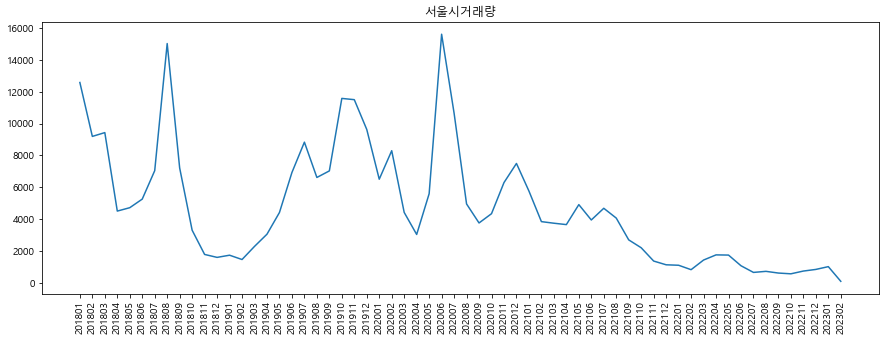

In [70]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.plot(df_거래량_서울전체["년도월"], df_거래량_서울전체["거래건수"])
plt.title("서울시거래량")

In [233]:
url ="https://www.reb.or.kr/r-one/statistics/getPriceIndicesListAJAX.do"
headers= {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36"}
data = {"aptType": 1, "trGbn": "S",
    "researchDate_s": "20180101",
    "researchDate_e": "20230206",
    "srchType": 1,
    "weekFlag": "W",
    "orderBy": "ASC",
    "regulation": "true",
    "gStatCd": "HOUSE_22110"}
re=requests.post(url, data=data,headers=headers,verify=False)
# re.encoding="UTF8"
data=json.loads(re.text)

In [283]:
pd.DataFrame(data["dataList"])[0:10]

,regionNm,level,order,20180101,20180101regulation,20180101rate,20180108,20180108regulation,20180108rate,20180115,...,20230123regulation,20230123rate,20230130,20230130regulation,20230130rate,20230206,20230206regulation,20230206rate,keyStr,_childList
0,전국,0,1,20180101,0.02,89.4,20180108,0.01,89.4,20180115,...,-0.42,96.5,20230130,-0.38,96.1,20230206,-0.49,95.7,"regionNm,20180101,20180108,20180115,20180122,2...",NaN
1,수도권,0,2,20180101,0.09,83.8,20180108,0.10,83.9,20180115,...,-0.48,95.5,20230130,-0.44,95.1,20230206,-0.58,94.5,"regionNm,20180101,20180108,20180115,20180122,2...",NaN
2,지방권,0,3,20180101,-0.05,95.1,20180108,-0.07,95,20180115,...,-0.35,97.4,20230130,-0.32,97.1,20230206,-0.40,96.8,"regionNm,20180101,20180108,20180115,20180122,2...",NaN
3,6대광역시,0,4,20180101,-0.02,86.2,20180108,-0.01,86.2,20180115,...,-0.43,94.2,20230130,-0.40,93.8,20230206,-0.49,93.3,"regionNm,20180101,20180108,20180115,20180122,2...",NaN
4,5대광역시,0,5,20180101,-0.02,87.5,20180108,-0.01,87.5,20180115,...,-0.43,94.2,20230130,-0.40,93.8,20230206,-0.49,93.4,"regionNm,20180101,20180108,20180115,20180122,2...",NaN
5,9개도,0,6,20180101,-0.04,91.2,20180108,-0.06,91.2,20180115,...,-0.43,98.6,20230130,-0.39,98.2,20230206,-0.52,97.7,"regionNm,20180101,20180108,20180115,20180122,2...",NaN
6,8개도,0,7,20180101,-0.08,103.4,20180108,-0.12,103.2,20180115,...,-0.26,101.2,20230130,-0.23,100.9,20230206,-0.29,100.6,"regionNm,20180101,20180108,20180115,20180122,2...",NaN
7,서울,0,8,20180101,0.26,90.9,20180108,0.29,91.2,20180115,...,-0.31,95,20230130,-0.25,94.7,20230206,-0.31,94.5,"regionNm,20180101,20180108,20180115,20180122,2...","[{'regionNm': '강북지역', 'level': '1', 'order': 9..."
8,경기,0,41,20180101,0.00,80.5,20180108,0.01,80.5,20180115,...,-0.59,96.1,20230130,-0.55,95.6,20230206,-0.75,94.9,"regionNm,20180101,20180108,20180115,20180122,2...","[{'regionNm': '경부1권', 'level': '1', 'order': 4..."
9,인천,0,98,20180101,-0.02,81.8,20180108,-0.02,81.8,20180115,...,-0.44,93.9,20230130,-0.39,93.6,20230206,-0.51,93.1,"regionNm,20180101,20180108,20180115,20180122,2...","[{'regionNm': '중구', 'level': '1', 'order': 99,..."


In [247]:
df_전체=pd.DataFrame(data["dataList"])

In [253]:
df_전체.columns

Index(['regionNm', 'level', 'order', '20180101', '20180101regulation',
       '20180101rate', '20180108', '20180108regulation', '20180108rate',
       '20180115',
       ...
       '20230123regulation', '20230123rate', '20230130', '20230130regulation',
       '20230130rate', '20230206', '20230206regulation', '20230206rate',
       'keyStr', '_childList'],
      dtype='object', length=806)

In [257]:
df_전국지역=df_전체.loc[:,df_전체.columns.str.contains("rate")]
df_전국지역["지역"]=df_전체["regionNm"]

In [260]:
df_전국지역=df_전국지역.set_index("지역")

In [262]:
df_전국지역.T

지역,전국,수도권,지방권,6대광역시,5대광역시,9개도,8개도,서울,경기,인천,...,울산,세종,강원,충북,충남,전북,전남,경북,경남,제주
20180101rate,89.4,83.8,95.1,86.2,87.5,91.2,103.4,90.9,80.5,81.8,...,100.3,68.5,105.3,102.5,97.4,101.7,93.8,106.9,109.9,96.4
20180108rate,89.4,83.9,95,86.2,87.5,91.2,103.2,91.2,80.5,81.8,...,100.2,68.5,105.2,102.3,97.2,101.6,93.8,106.8,109.8,96.4
20180115rate,89.4,84,95,86.2,87.4,91.2,103.2,91.5,80.5,81.8,...,100,68.5,105.2,102.2,97.2,101.5,93.9,106.6,109.6,96.3
20180122rate,89.5,84.1,94.9,86.2,87.4,91.1,103.1,91.9,80.6,81.8,...,99.9,68.6,105.1,102,97.2,101.5,94,106.5,109.4,96.4
20180129rate,89.5,84.2,94.9,86.2,87.5,91.1,103,92.2,80.6,81.8,...,99.8,68.6,105.2,101.8,97.1,101.5,94.1,106.4,109.2,96.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20230109rate,97.4,96.5,98.2,95.1,95.1,99.5,101.7,95.6,97.4,95,...,96.4,78.6,104.4,103.8,102.7,104.6,97.2,100.6,99.7,106.9
20230116rate,96.9,95.9,97.8,94.6,94.6,99,101.4,95.3,96.7,94.4,...,96.1,77.7,104.3,103.5,102.5,104.4,96.8,100.4,99.2,106.8
20230123rate,96.5,95.5,97.4,94.2,94.2,98.6,101.2,95,96.1,93.9,...,95.8,76.9,104.2,103.3,102.2,104.2,96.4,100.2,98.9,106.6
20230130rate,96.1,95.1,97.1,93.8,93.8,98.2,100.9,94.7,95.6,93.6,...,95.5,76.1,104.1,103,102,103.9,96.1,100,98.6,106.4


In [272]:
pd.DataFrame(df_전체.loc[df_전체["regionNm"]=="서울", "_childList"].values[0])

,regionNm,level,order,20180101,20180101regulation,20180101rate,20180108,20180108regulation,20180108rate,20180115,...,20230123regulation,20230123rate,20230130,20230130regulation,20230130rate,20230206,20230206regulation,20230206rate,keyStr,_childList
0,강북지역,1,9,20180101,0.11,90.8,20180108,0.13,90.9,20180115,...,-0.30,92.7,20230130,-0.21,92.5,20230206,-0.28,92.2,"regionNm,20180101,20180108,20180115,20180122,2...","[{'regionNm': '도심권', 'level': '2', 'order': 10..."
1,강남지역,1,27,20180101,0.39,91,20180108,0.42,91.4,20180115,...,-0.32,97,20230130,-0.29,96.7,20230206,-0.33,96.4,"regionNm,20180101,20180108,20180115,20180122,2...","[{'regionNm': '서남권', 'level': '2', 'order': 28..."


In [271]:
df_서울1=pd.DataFrame(df_전체.loc[df_전체["regionNm"]=="서울", "_childList"].values[0])

In [274]:
df_서울2=pd.DataFrame(df_서울1.loc[df_서울1["regionNm"]=="강남지역", "_childList"].values[0])
df_서울2

,regionNm,level,order,20180101,20180101regulation,20180101rate,20180108,20180108regulation,20180108rate,20180115,...,20230123regulation,20230123rate,20230130,20230130regulation,20230130rate,20230206,20230206regulation,20230206rate,keyStr,_childList
0,서남권,2,28,20180101,0.13,90.3,20180108,0.22,90.5,20180115,...,-0.41,95.9,20230130,-0.36,95.6,20230206,-0.40,95.2,"regionNm,20180101,20180108,20180115,20180122,2...","[{'regionNm': '양천구', 'level': '3', 'order': 29..."
1,동남권,2,36,20180101,0.69,91.9,20180108,0.65,92.5,20180115,...,-0.22,98.3,20230130,-0.22,98.1,20230206,-0.25,97.8,"regionNm,20180101,20180108,20180115,20180122,2...","[{'regionNm': '서초구', 'level': '3', 'order': 37..."


In [276]:
df_서울3=pd.DataFrame(df_서울2.loc[df_서울2["regionNm"]=="서남권", "_childList"].values[0])
df_서울3

,regionNm,level,order,20180101,20180101regulation,20180101rate,20180108,20180108regulation,20180108rate,20180115,...,20230123,20230123regulation,20230123rate,20230130,20230130regulation,20230130rate,20230206,20230206regulation,20230206rate,keyStr
0,양천구,3,29,20180101,0.23,90.2,20180108,0.77,90.9,20180115,...,20230123,-0.18,96.4,20230130,-0.17,96.3,20230206,-0.18,96.1,"regionNm,20180101,20180108,20180115,20180122,2..."
1,강서구,3,30,20180101,0.09,91.4,20180108,0.07,91.4,20180115,...,20230123,-0.66,95.5,20230130,-0.62,94.9,20230206,-0.58,94.3,"regionNm,20180101,20180108,20180115,20180122,2..."
2,구로구,3,31,20180101,0.03,90.2,20180108,0.10,90.3,20180115,...,20230123,-0.50,96.5,20230130,-0.34,96.1,20230206,-0.40,95.8,"regionNm,20180101,20180108,20180115,20180122,2..."
3,금천구,3,32,20180101,0.00,92.4,20180108,-0.02,92.4,20180115,...,20230123,-0.55,93.8,20230130,-0.51,93.3,20230206,-0.57,92.8,"regionNm,20180101,20180108,20180115,20180122,2..."
4,영등포구,3,33,20180101,0.08,88.5,20180108,0.08,88.5,20180115,...,20230123,-0.37,95,20230130,-0.37,94.6,20230206,-0.35,94.3,"regionNm,20180101,20180108,20180115,20180122,2..."
5,동작구,3,34,20180101,0.33,88.8,20180108,0.21,89,20180115,...,20230123,-0.20,97.8,20230130,-0.17,97.6,20230206,-0.39,97.2,"regionNm,20180101,20180108,20180115,20180122,2..."
6,관악구,3,35,20180101,0.08,91.6,20180108,0.07,91.6,20180115,...,20230123,-0.45,95.3,20230130,-0.40,95,20230206,-0.47,94.5,"regionNm,20180101,20180108,20180115,20180122,2..."


#### [국토부 실거래가 활용]

In [91]:
df.set_index("거래일자")["관할구"].resample("1M").count()

거래일자
2022-01-31    1139
2022-02-28     856
2022-03-31    1501
2022-04-30    1837
2022-05-31    1844
2022-06-30    1140
2022-07-31     688
2022-08-31     760
2022-09-30     649
2022-10-31     574
2022-11-30     752
2022-12-31     894
2023-01-31     817
2023-02-28      16
Freq: M, Name: 관할구, dtype: int64

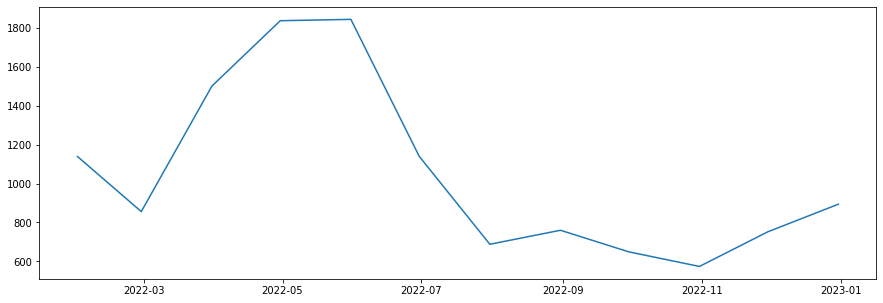

In [93]:
d=df.set_index("거래일자")["관할구"].resample("1M").count()[0:-2]
plt.figure(figsize=(15,5))
plt.plot(d)

In [108]:
df.set_index("거래일자").groupby(by="관할구")["법정동"].resample("1M").count()

관할구        거래일자      
서울특별시 강남구  2022-01-31     60
           2022-02-28     67
           2022-03-31     93
           2022-04-30    113
           2022-05-31    114
                        ... 
서울특별시 중랑구  2022-09-30     32
           2022-10-31     23
           2022-11-30     16
           2022-12-31     15
           2023-01-31     27
Name: 법정동, Length: 337, dtype: int64

In [107]:
d=df.set_index("거래일자").groupby(by="관할구")["법정동"].resample("1M").count().reset_index()
d.groupby(by="거래일자")[["관할구","법정동"]].apply(lambda x : x.sort_values(by="법정동", ascending=False))

관할구  법정동
거래일자                           
2022-01-31 80    서울특별시 구로구  151
           40    서울특별시 강서구   99
           108   서울특별시 노원구   68
           284   서울특별시 은평구   61
           0     서울특별시 강남구   60
...                    ...  ...
2023-02-28 107   서울특별시 금천구    1
           147  서울특별시 동대문구    1
           201   서울특별시 서초구    1
           242   서울특별시 송파구    1
           270  서울특별시 영등포구    1

[337 rows x 2 columns]

#### 2. 최근거래가 직전거래가보다  낮은 비율(단, 같은 관할구, 법정동,아파트명,전용면적)

In [37]:
# df_droprate=df.groupby(by=["관할구", "법정동","아파트명","전용면적")["거래금액"].apply(lambda x : (x.min()-x.max())/x.max()*100)
# df_droprate=df_droprate.reset_index()
# df_droprate=df_droprate.rename(columns={"거래금액": "하락률"})
# df_droprate.sort_values(by="하락률")[0:50]

In [43]:
# groupby 관할구 추가 필요!!!!!!!!!
# 그룹으로 구분하여 그룹내 최대값, 최소값 찾기

# [최대값, 최소값]의 리스트형 요소의 열 생성 
df_gr_minmax=df.groupby(by=["관할구", "법정동","아파트명","전용면적"])["거래금액"].apply(lambda x : [x.max(), x.min()])
df_gr_minmax=df_gr_minmax.reset_index()

# [최대값, 최소값]의 첫 번째, 두 번째 선택
df_gr_minmax["최고가"]=df_gr_minmax["거래금액"].map(lambda x : x[0])
df_gr_minmax["최저가"]=df_gr_minmax["거래금액"].map(lambda x : x[1])

# 하락률 계산
df_gr_minmax=df_gr_minmax.drop("거래금액",axis=1)
df_gr_minmax["하락률"]=(df_gr_minmax["최저가"]-df_gr_minmax["최고가"])/df_gr_minmax["최고가"]*100
df_gr_minmax.sort_values(by="하락률")[0:50]

,관할구,법정동,아파트명,전용면적,최고가,최저가,하락률
6307,서울특별시 중구,회현동2가,쌍용남산플래티넘,166.24,185000,83000,-55.135135
2232,서울특별시 노원구,공릉동,미라쉘,16.69,20000,9300,-53.500000
3884,서울특별시 서초구,반포동,반포주공1단지,107.47,590000,287000,-51.355932
703,서울특별시 강동구,암사동,선사현대아파트,59.64,117000,58000,-50.427350
4369,서울특별시 성동구,응봉동,대림강변타운,59.76,128000,64700,-49.453125
161,서울특별시 강남구,도곡동,도곡렉슬,84.9984,315000,160000,-49.206349
3555,서울특별시 마포구,염리동,우리파크아파트,22.92,61000,31000,-49.180328
1538,서울특별시 광진구,광장동,현대3,59.67,127000,66000,-48.031496
2866,서울특별시 동대문구,답십리동,힐스테이트청계,84.85,148000,77000,-47.972973
4797,서울특별시 송파구,방이동,올림픽선수기자촌2단지,100.31,230000,120500,-47.608696


In [39]:
# 변수 추가하고 초기값 설정
df_gr_minmax["건축년도"]=np.nan
df_gr_minmax["최고가_층"]=np.nan
df_gr_minmax["최저가_층"]=np.nan
df_gr_minmax["최고가_거래일자"]=np.nan
df_gr_minmax["최저가_거래일자"]=np.nan

In [40]:
# 건축년도, 최고가층, 최고가 거래일자,  최저가층, 최저가 거래일자 추가 
for i, (gu, dong, apt, area)  in enumerate(zip(df_gr_minmax["관할구"], df_gr_minmax["법정동"], df_gr_minmax["아파트명"],df_gr_minmax["전용면적"])):
    
# 원데이터에서 그룹조건의 행 찾기
    gr=df[(df["관할구"] ==gu) & (df["법정동"] ==dong) & (df["아파트명"] ==apt) & (df["전용면적"] ==area)]

#  원데이터(그룹의 최대값, 최소값의 조건 )에서 층, 건축년도 찾기         
    df_gr_minmax["건축년도"].iloc[i]=gr["건축년도"].iloc[0]
    df_gr_minmax["최고가_층"].iloc[i] = gr[gr["거래금액"]==gr["거래금액"].max()]["층"].iloc[0]
    df_gr_minmax["최저가_층"].iloc[i] = gr[gr["거래금액"]==gr["거래금액"].min()]["층"].iloc[0]   
    
# 원데이터(그룹의 최대값, 최소값의 조건 )에서 거래일자 찾기  
    df_gr_minmax["최고가_거래일자"].iloc[i] = gr[gr["거래금액"]==gr["거래금액"].max()]["거래일자"].iloc[0]
    df_gr_minmax["최저가_거래일자"].iloc[i] = gr[gr["거래금액"]==gr["거래금액"].min()]["거래일자"].iloc[0]   

In [41]:
# 날자형 포멧 변경
df_gr_minmax["최고가_거래일자"]=df_gr_minmax["최고가_거래일자"].map(lambda x : datetime.datetime.strftime(x,"%Y-%m-%d"))
df_gr_minmax["최저가_거래일자"]=df_gr_minmax["최저가_거래일자"].map(lambda x : datetime.datetime.strftime(x,"%Y-%m-%d"))

In [42]:
# csv파일로 저장
df_gr_minmax[df_gr_minmax["하락률"]!=0].sort_values(by="하락률").reset_index(drop=True).to_csv("서울실거래가하락률.csv", encoding="cp949")

## [경기도]

### 법정동코드 생성

In [44]:
# 경기도 법정동코드 
df_code = pd.read_csv('법정동코드 전체자료.txt', sep="\t", encoding="cp949")
df_code_경기도=df_code[(df_code["법정동명"].str.contains("경기도")) & (df_code["폐지여부"]=="존재")]
df_code_경기도

,법정동코드,법정동명,폐지여부
4475,4100000000,경기도,존재
4824,4111000000,경기도 수원시,존재
4889,4111100000,경기도 수원시 장안구,존재
4918,4111112900,경기도 수원시 장안구 파장동,존재
4919,4111113000,경기도 수원시 장안구 정자동,존재
...,...,...,...
10092,4183041029,경기도 양평군 개군면 내리,존재
10093,4183041030,경기도 양평군 개군면 향리,존재
10094,4183041031,경기도 양평군 개군면 주읍리,존재
10095,4183041032,경기도 양평군 개군면 계전리,존재


In [45]:
df_code_경기도[(df_code_경기도["법정동명"].str.contains("광명"))]

,법정동코드,법정동명,폐지여부
5344,4121000000,경기도 광명시,존재
5345,4121010100,경기도 광명시 광명동,존재
5346,4121010200,경기도 광명시 철산동,존재
5347,4121010300,경기도 광명시 하안동,존재
5348,4121010400,경기도 광명시 소하동,존재
5349,4121010500,경기도 광명시 노온사동,존재
5350,4121010600,경기도 광명시 일직동,존재
5351,4121010700,경기도 광명시 가학동,존재
5352,4121010800,경기도 광명시 옥길동,존재


In [46]:
# 법정명에서 "구"로 끝나는 것 
df_code_경기구=df_code_경기도[df_code_경기도["법정동명"].str.endswith("구") ]
df_code_경기구=df_code_경기구.reset_index(drop=True)
df_code_경기구["법정동코드"]=df_code_경기구["법정동코드"].astype("str")
df_code_경기구["법정동코드"]=df_code_경기구["법정동코드"].map(lambda x : x[0:5])

In [47]:
print(list(zip(df_code_경기구["법정동코드"],df_code_경기구["법정동명"])))

[('41111', '경기도 수원시 장안구'), ('41113', '경기도 수원시 권선구'), ('41115', '경기도 수원시 팔달구'), ('41117', '경기도 수원시 영통구'), ('41131', '경기도 성남시 수정구'), ('41133', '경기도 성남시 중원구'), ('41135', '경기도 성남시 분당구'), ('41171', '경기도 안양시 만안구'), ('41173', '경기도 안양시 동안구'), ('41271', '경기도 안산시 상록구'), ('41273', '경기도 안산시 단원구'), ('41281', '경기도 고양시 덕양구'), ('41285', '경기도 고양시 일산동구'), ('41287', '경기도 고양시 일산서구'), ('41461', '경기도 용인시 처인구'), ('41463', '경기도 용인시 기흥구'), ('41465', '경기도 용인시 수지구')]


In [48]:
# "구"가 없는 "시" 찾기
df_code_경기시=df_code_경기도[df_code_경기도["법정동명"].str.endswith("시") ]
df_code_경기시=df_code_경기시[~df_code_경기시["법정동명"].isin(["경기도 수원시","경기도 성남시",
                                                  "경기도 안양시","경기도 안산시", "경기도 고양시","경기도 용인시"])]
df_code_경기시["법정동코드"]=df_code_경기시["법정동코드"].astype("str")
df_code_경기시["법정동코드"]=df_code_경기시["법정동코드"].map(lambda x : x[0:5])
print(list(zip(df_code_경기시["법정동코드"],df_code_경기시["법정동명"])))

[('41150', '경기도 의정부시'), ('41190', '경기도 부천시'), ('41210', '경기도 광명시'), ('41220', '경기도 평택시'), ('41250', '경기도 동두천시'), ('41290', '경기도 과천시'), ('41310', '경기도 구리시'), ('41360', '경기도 남양주시'), ('41370', '경기도 오산시'), ('41390', '경기도 시흥시'), ('41410', '경기도 군포시'), ('41430', '경기도 의왕시'), ('41450', '경기도 하남시'), ('41480', '경기도 파주시'), ('41500', '경기도 이천시'), ('41550', '경기도 안성시'), ('41570', '경기도 김포시'), ('41590', '경기도 화성시'), ('41610', '경기도 광주시'), ('41630', '경기도 양주시'), ('41650', '경기도 포천시'), ('41670', '경기도 여주시')]


In [49]:
# 법정코드 : 문자열로 변경하고 앞 5개 수자 가져오기
df_code_경기시=df_code_경기시.reset_index(drop=True)
df_code_경기시["법정동코드"]=df_code_경기시["법정동코드"].astype("str")
df_code_경기시["법정동코드"]=df_code_경기시["법정동코드"].map(lambda x : x[0:5])

In [50]:
print(list(zip(df_code_경기시["법정동코드"],df_code_경기시["법정동명"])))

[('41150', '경기도 의정부시'), ('41190', '경기도 부천시'), ('41210', '경기도 광명시'), ('41220', '경기도 평택시'), ('41250', '경기도 동두천시'), ('41290', '경기도 과천시'), ('41310', '경기도 구리시'), ('41360', '경기도 남양주시'), ('41370', '경기도 오산시'), ('41390', '경기도 시흥시'), ('41410', '경기도 군포시'), ('41430', '경기도 의왕시'), ('41450', '경기도 하남시'), ('41480', '경기도 파주시'), ('41500', '경기도 이천시'), ('41550', '경기도 안성시'), ('41570', '경기도 김포시'), ('41590', '경기도 화성시'), ('41610', '경기도 광주시'), ('41630', '경기도 양주시'), ('41650', '경기도 포천시'), ('41670', '경기도 여주시')]


In [51]:
# "구"와 "시" 합치기
df_code_경기_법정동코드=pd.concat([df_code_경기구["법정동코드"],df_code_경기시["법정동코드"]], axis=0)
df_code_경기_법정동명=pd.concat([df_code_경기구["법정동명"],df_code_경기시["법정동명"]], axis=0)

In [52]:
# 기간 설정
date=['202201','202202','202203','202204','202205','202206','202207','202208','202209','202210','202211','202212',
      '202301', '202302']

### 웹 크롤링

In [53]:
# data.go.kr에서 "아파트매매 실거래자료" open api 검색
# LAWD_CD : 각 지역별 코드 행정표준코드관리시스템(www.code.go.kr)의 법정동코드 10자리 중 앞 5자리
# DEAL_YMD : 실거래 자료의 계약년월(6자리)
url = 'http://openapi.molit.go.kr:8081/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTrade'

전체실거래=[]
for i, (code, name)  in enumerate(zip(df_code_경기_법정동코드,df_code_경기_법정동명)):
    for month in date:
        params ={'serviceKey' : '2v9BFwIA8yoMw1cY29jvpynp24zpowZcL+UpOr31S/sVqRxCT1fYaTHov1dhMMdEp1GNFkeLl9dAHmSl5z6NBw==','LAWD_CD' : code, 'DEAL_YMD' : month }
        response = requests.get(url, params=params)
        soup=BeautifulSoup(response.text,"xml")
        for item in soup.select("item"):
            실거래=[]
            실거래.append(item.select_one("거래금액").text)
            실거래.append(name)
            실거래.append(item.select_one("법정동").text)
            실거래.append(item.select_one("아파트").text)
            실거래.append(item.select_one("전용면적").text)
            실거래.append(item.select_one("층").text)
            실거래.append(item.select_one("건축년도").text)
            실거래.append(item.select_one("년").text)
            실거래.append(item.select_one("월").text)
            실거래.append(item.select_one("일").text)
            전체실거래.append(실거래)

In [54]:
df_경기=pd.DataFrame(전체실거래, columns=["거래금액","관할구","법정동","아파트명","전용면적","층","건축년도","거래년","거래월","거래일"])

### 데이터 분석

In [55]:
df=df_경기.copy()
df=df.apply(lambda column : column.map(lambda ele : ele.strip()))

In [56]:
df["거래월"]=df["거래월"].map(lambda x : x.zfill(2))
df["거래일"]=df["거래일"].map(lambda x : x.zfill(2))

In [57]:
df["거래일자"]=df["거래년"]+df["거래월"]+df["거래일"]
df=df.drop(["거래년", "거래월","거래일"],axis=1)
columns=['관할구', '법정동', '아파트명', '전용면적', '층', '건축년도','거래금액', '거래일자']
df=df[columns]

In [58]:
df["거래일자"]=pd.to_datetime(df["거래일자"])

In [59]:
df["거래금액"]=df["거래금액"].str.replace(",","")
df["거래금액"]=df["거래금액"].astype("int")

In [60]:
df.sort_values(by="거래일자",ascending=False)[0:10]

,관할구,법정동,아파트명,전용면적,층,건축년도,거래금액,거래일자
8676,경기도 안산시 단원구,초지동,초지역메이저타운푸르지오메트로단지,59.9333,15,2019,56000,2023-02-04
8678,경기도 안산시 단원구,선부동,군자주공15(저층),39.61,3,1992,30000,2023-02-04
26436,경기도 평택시,비전동,평택,63.17,5,1979,11500,2023-02-03
26437,경기도 평택시,비전동,비전경남아너스빌,84.986,11,2009,26200,2023-02-03
26934,경기도 동두천시,상패동,상패주공,49.84,6,1997,10400,2023-02-03
26442,경기도 평택시,팽성읍 송화리,영동,47.88,3,1991,6500,2023-02-03
44327,경기도 김포시,운양동,한강신도시롯데캐슬,122.7335,2,2014,62000,2023-02-03
26440,경기도 평택시,용이동,평택비전에듀포레푸르지오,84.955,11,2018,47000,2023-02-03
51016,경기도 포천시,신읍동,은하,46.92,2,1985,6800,2023-02-03
9996,경기도 고양시 덕양구,행신동,무원마을1단지,68.98,2,1995,34500,2023-02-03


In [61]:
# df_droprate=df.groupby(by=["법정동","아파트명","전용면적"])["거래금액"].apply(lambda x : (x.min()-x.max())/x.max()*100)
# df_droprate=df_droprate.reset_index()
# df_droprate=df_droprate.rename(columns={"거래금액": "하락률"})
# df_droprate.sort_values(by="하락률")[0:50]

In [68]:
df_gr_minmax=df.groupby(by=["관할구", "법정동","아파트명","전용면적"])["거래금액"].apply(lambda x : [x.max(), x.min()])
df_gr_minmax=df_gr_minmax.reset_index()
df_gr_minmax["최고가"]=df_gr_minmax["거래금액"].map(lambda x : x[0])
df_gr_minmax["최저가"]=df_gr_minmax["거래금액"].map(lambda x : x[1])
df_gr_minmax=df_gr_minmax.drop("거래금액",axis=1)
df_gr_minmax["하락률"]=(df_gr_minmax["최저가"]-df_gr_minmax["최고가"])/df_gr_minmax["최고가"]*100
df_gr_minmax.sort_values(by="하락률")[0:50]

,관할구,법정동,아파트명,전용면적,최고가,최저가,하락률
4044,경기도 부천시,옥길동,엘에이치옥길헤일라움,59.6,68000,25417,-62.622059
68,경기도 고양시 덕양구,도내동,도래울센트럴더힐,59.95,62500,24198,-61.283200
7941,경기도 안양시 만안구,안양동,향림,47.31,24100,10000,-58.506224
7571,경기도 안양시 동안구,평촌동,인덕원대우,84.96,97000,42000,-56.701031
7293,경기도 안성시,공도읍 진사리,주은청설,39.75,18200,7900,-56.593407
7802,경기도 안양시 만안구,안양동,래미안안양메가트리아,39.5,46000,20000,-56.521739
5342,경기도 수원시 권선구,호매실동,호매실마을13단지,59.93,56000,25000,-55.357143
3008,경기도 남양주시,진접읍 장현리,현대,51.296,20000,9000,-55.000000
11951,경기도 평택시,포승읍 만호리,더스위트하버,25.49,8600,3900,-54.651163
489,경기도 고양시 일산동구,백석동,일산요진와이시티,84.49,122000,56000,-54.098361


In [63]:
# 건축년도, 최고가층, 최고가 거래일자,  최저가층, 최저가 거래일자 추가 
df_gr_minmax["건축년도"]=np.nan
df_gr_minmax["최고가_층"]=np.nan
df_gr_minmax["최저가_층"]=np.nan
df_gr_minmax["최고가_거래일자"]=np.nan
df_gr_minmax["최저가_거래일자"]=np.nan

In [64]:
for i, (gu, dong, apt, area)  in enumerate(zip(df_gr_minmax["관할구"], df_gr_minmax["법정동"], df_gr_minmax["아파트명"],df_gr_minmax["전용면적"])):
    gr=df[(df["관할구"] ==gu) & (df["법정동"] ==dong) & (df["아파트명"] ==apt) & (df["전용면적"] ==area)]
    df_gr_minmax["건축년도"].iloc[i]=gr["건축년도"].iloc[0]
    df_gr_minmax["최고가_층"].iloc[i] = gr[gr["거래금액"]==gr["거래금액"].max()]["층"].iloc[0]
    df_gr_minmax["최저가_층"].iloc[i] = gr[gr["거래금액"]==gr["거래금액"].min()]["층"].iloc[0]   
    df_gr_minmax["최고가_거래일자"].iloc[i] = gr[gr["거래금액"]==gr["거래금액"].max()]["거래일자"].iloc[0]
    df_gr_minmax["최저가_거래일자"].iloc[i] = gr[gr["거래금액"]==gr["거래금액"].min()]["거래일자"].iloc[0]   

In [65]:
df_gr_minmax["최고가_거래일자"]=df_gr_minmax["최고가_거래일자"].map(lambda x : datetime.datetime.strftime(x,"%Y-%m-%d"))
df_gr_minmax["최저가_거래일자"]=df_gr_minmax["최저가_거래일자"].map(lambda x : datetime.datetime.strftime(x,"%Y-%m-%d"))

In [66]:
df_gr_minmax[df_gr_minmax["하락률"]!=0].sort_values(by="하락률").reset_index(drop=True).to_csv("경기실거래가하락률.csv", encoding="cp949")

### 코딩 확인

In [21]:
# data.go.kr에서 "아파트매매 실거래자료" open api 검색
# LAWD_CD : 각 지역별 코드 행정표준코드관리시스템(www.code.go.kr)의 법정동코드 10자리 중 앞 5자리
# DEAL_YMD : 실거래 자료의 계약년월(6자리)
url = 'http://openapi.molit.go.kr:8081/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTrade'
params ={'serviceKey' : '2v9BFwIA8yoMw1cY29jvpynp24zpowZcL+\
UpOr31S/sVqRxCT1fYaTHov1dhMMdEp1GNFkeLl9dAHmSl5z6NBw==',
         'LAWD_CD' : '11500', 'DEAL_YMD' : '202211' }

response = requests.get(url, params=params)

In [ ]:
# xml 타입 parsing
soup=BeautifulSoup(response.text,"xml")

In [ ]:
# 수직으로 표현하기
print(soup.prettify())

In [ ]:
# BeautifulSoup 객체내 모든 요소 탐색
soup.select("item")

In [ ]:
# BeautifulSoup 객체내 요소 탐색
전체실거래=[]
for item in soup.select("item"):
    실거래=[]
    실거래.append(item.select_one("거래금액").text)
    실거래.append(item.select_one("법정동").text)
    실거래.append(item.select_one("아파트").text)
    실거래.append(item.select_one("전용면적").text)
    실거래.append(item.select_one("층").text)
    실거래.append(item.select_one("건축년도").text)
    실거래.append(item.select_one("년").text)
    실거래.append(item.select_one("월").text)
    실거래.append(item.select_one("일").text)
    전체실거래.append(실거래)

In [ ]:
pd.DataFrame(전체실거래, columns=["거래금액","법정동","아파트명","전용면적","층","건축년도","거래년","거래월","거래일"])

In [ ]:
soup.find_all("item")[0].find("거래금액").text

In [ ]:
df_code = pd.read_csv('법정동코드 전체자료.txt', sep="\t", encoding="cp949")

In [ ]:
df_code_서울특별시 =df_code[(df_code["법정동명"].str.contains("서울특별시")) & (df_code["폐지여부"]=="존재")]

In [ ]:
df_code_서울구=df_code_서울특별시[df_code_서울특별시["법정동명"].str.endswith("구") ]

In [ ]:
df_code_서울구=df_code_서울구.reset_index(drop=True)

In [ ]:
df_code_서울구

In [ ]:
df_code_서울구["법정동코드"]=df_code_서울구["법정동코드"].astype("str")

In [ ]:
df_code_서울구["법정동코드"].map(lambda x : x[0:5])